> Assign -1 for similarity if there is missing in either of the Fields 
(No additional columns)

In [1]:
import pandas as pd
import numpy as np
import libact
from libact.models import SVM
from libact.query_strategies import QUIRE, UncertaintySampling, RandomSampling, ActiveLearningByLearning, HintSVM
import warnings
import matplotlib.pyplot as plt
from libact.models import SklearnAdapter
from sklearn import tree
import seaborn as sbn
import time
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
from Utils import *
from Similarity import *

- Get the Data

In [4]:
phone_path ='/Users/bengikoseoglu/Documents/Masters/Semester4/Thesis/Notebooks/1_Merging/hp_merged.csv'
phone_result=pd.read_csv(phone_path)
phone_result.head()

,Unnamed: 0,id_webpage,match,page_headphones_form_factor,page_mpn,page_product_gtin,page_warc,page_color,page_brand,page_model,page_url,page_connectivity_technology,page_series,page_sensitivity,page_product_type,page_headphones_technology,page_weight,page_frequency_response,page_impedance,page_compatibility,page_thd,page_included_accessories,page_warranty,page_microphone_sensitivity,page_height,page_microphone,page_headphones_cup_type,page_max_input_power,page_width,page_cables_included,page_magnet_material,cat_headphones_technology,cat_controls,cat_brand,cat_compliant_standards,cat_diaphragm,cat_warranty,cat_foldable,cat_product_type,cat_headphones_form_factor,cat_model,cat_height,cat_depth,cat_connectivity_technology,cat_thd,cat_width,cat_product_gtin,cat_series,cat_included_accessories,cat_impedance,cat_frequency_response,cat_magnet_material,cat_compatibility,cat_microphone_response,cat_max_input_power,cat_cables_included,cat_mpn,cat_microphone,cat_detachable_cable,cat_weight,cat_microphone_sensitivity,cat_sound_output_mode,cat_sensitivity,cat_color,cat_microphone_audio_details,cat_headphones_cup_type,cat_aditional_features,cat_mdoel,prodcat_product_name,prodcat_id,id
0,0,node449b610bd3ad6439d1b26190266d5,0,ear-cup (over the ear),does not apply,does not apply,ebay.com0.warc.nq.gz,black,akg,k712 pro,http://www.ebay.com/itm/brand-new-akg-k712-pro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62 ohms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,open-air type,NaN,NaN,NaN,NaN,dynamic,NaN,audio-technica,NaN,1.8 in,2 years,yes,headphones,"full size, circumaural",ath-m50x,NaN,NaN,wired,NaN,NaN,04961310125431,m series,"headphones pouch, 6.3 mm (1/4"") stereo adapter",38 ohm,15 - 28000 hz,neodymium,NaN,NaN,"1,600 mw at 1 khz",2 x headphones cable - external - 10 ft headph...,"ath m-50x, ath-m50x bk (black), atath-m50x",NaN,yes,"10.02 oz, 285 g",NaN,stereo,99 db,black,NaN,closed,NaN,NaN,audio technica ath-m50x,d7130c90-df60-4e0d-a898-ad8e2821dc7f,fa07e48a-7a42-11e9-a70d-9a0011fd23e0
1,1,node4b4dee215b51f2eb45a114409ce7eda6,0,ear-cup (over the ear),does not apply,does not apply,ebay.com0.warc.nq.gz,black,akg,k712 pro,http://www.ebay.com/itm/brand-new-akg-k712-pro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62 ohms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,open-air type,NaN,NaN,NaN,NaN,dynamic,NaN,audio-technica,NaN,1.8 in,2 years,yes,headphones,"full size, circumaural",ath-m50x,NaN,NaN,wired,NaN,NaN,04961310125431,m series,"headphones pouch, 6.3 mm (1/4"") stereo adapter",38 ohm,15 - 28000 hz,neodymium,NaN,NaN,"1,600 mw at 1 khz",2 x headphones cable - external - 10 ft headph...,"ath m-50x, ath-m50x bk (black), atath-m50x",NaN,yes,"10.02 oz, 285 g",NaN,stereo,99 db,black,NaN,closed,NaN,NaN,audio technica ath-m50x,d7130c90-df60-4e0d-a898-ad8e2821dc7f,fa07e5f2-7a42-11e9-a70d-9a0011fd23e0
2,2,node52a9f6bc8fa1772a0f6a2832641fa1,0,NaN,does not apply,does not apply,ebay.com0.warc.nq.gz,NaN,akg,k712 pro,http://www.ebay.com/itm/brand-new-akg-k712-pro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,open-air type,NaN,NaN,NaN,NaN,dynamic,NaN,audio-technica,NaN,1.8 in,2 years,yes,headphones,"full size, circumaural",ath-m50x,NaN,NaN,wired,NaN,NaN,04961310125431,m series,"headphones pouch, 6.3 mm (1/4"") stereo adapter",38 ohm,15 - 28000 hz,neodymium,NaN,NaN,"1,600 mw at 1 khz",2 x headphones cable - external - 10 ft headph...,"ath m-50x, ath-m50x bk (black), atath-m50x",NaN,yes,"10.02 oz, 285 g",NaN,stereo,99 db,black,NaN,closed,NaN,NaN,audio technica ath-m50x,d7130c90-df60-4e0d-a898-ad8e2821dc7f,fa07e656-7a42-11e9-a70d-9a0011fd23e0
3,3,node6d72a28b4e6d7d1aff11ebab95221fa1,0,ear-cup (over the ear),does not apply,does not apply,ebay.com0.warc.nq.gz,black,akg,k712 pro,http://www.ebay.com/itm/brand-new-akg-k712-pro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62 ohms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,open-air type,NaN,NaN,NaN,NaN,dynamic,NaN,audio-technica,NaN,1.8 in,2 years,yes,headphones,"full size, circumaural",ath-m50x,NaN,NaN,wired,NaN,NaN,04961310125431,m series,"headphones pouch, 6.3 mm (1/4"") stereo adapt

In [5]:
phone_result.shape

(23087, 71)

- Choose attributes

In [6]:
# columns that only exist in pages
only_page_columns=[]
print(len(only_page_columns))

0


In [7]:
# columns that only exist in catalog
only_cat_columns=['cat_controls', 'cat_compliant_standards', 'cat_diaphragm', 'cat_foldable', 'cat_depth', 'cat_microphone_response', 'cat_detachable_cable', 'cat_sound_output_mode', 'cat_microphone_audio_details', 'cat_aditional_features','cat_mdoel']
print(len(only_cat_columns))

11


In [8]:
# columns that are ids, target and matching attributes
matches=['id_webpage','prodcat_id', 'page_url', 'page_warc', 'prodcat_product_name','match','cat_product_gtin','page_product_gtin', 'cat_product_type', 'page_product_type','cat_model','page_model','cat_brand', 'page_brand', 'cat_microphone', 'page_microphone','cat_connectivity_technology','page_connectivity_technology', 'cat_thd','page_thd', 'cat_warranty', 'page_warranty', 'cat_headphones_form_factor', 'page_headphones_form_factor', 'cat_included_accessories', 'page_included_accessories', 'cat_impedance', 'page_impedance', 'cat_frequency_response', 'page_frequency_response', 'cat_magnet_material', 'page_magnet_material', 'cat_compatibility', 'page_compatibility', 'cat_cables_included', 'page_cables_included', 'cat_mpn', 'page_mpn', 'cat_weight', 'page_weight', 'cat_height', 'page_height', 'cat_width', 'page_width', 'cat_headphones_cup_type','page_headphones_cup_type', 'cat_headphones_technology', 'page_headphones_technology', 'cat_max_input_power', 'page_max_input_power', 'cat_microphone_sensitivity', 'page_microphone_sensitivity', 'cat_sensitivity', 'page_sensitivity', 'cat_color', 'page_color', 'cat_series', 'page_series']
print(len(matches))

58


In [9]:
cols_inorder= matches.copy()
cols_inorder.extend(only_cat_columns)
cols_inorder.extend(only_page_columns)
phone_result_sub=phone_result[cols_inorder]
phone_result_sub.head()

,id_webpage,prodcat_id,page_url,page_warc,prodcat_product_name,match,cat_product_gtin,page_product_gtin,cat_product_type,page_product_type,cat_model,page_model,cat_brand,page_brand,cat_microphone,page_microphone,cat_connectivity_technology,page_connectivity_technology,cat_thd,page_thd,cat_warranty,page_warranty,cat_headphones_form_factor,page_headphones_form_factor,cat_included_accessories,page_included_accessories,cat_impedance,page_impedance,cat_frequency_response,page_frequency_response,cat_magnet_material,page_magnet_material,cat_compatibility,page_compatibility,cat_cables_included,page_cables_included,cat_mpn,page_mpn,cat_weight,page_weight,cat_height,page_height,cat_width,page_width,cat_headphones_cup_type,page_headphones_cup_type,cat_headphones_technology,page_headphones_technology,cat_max_input_power,page_max_input_power,cat_microphone_sensitivity,page_microphone_sensitivity,cat_sensitivity,page_sensitivity,cat_color,page_color,cat_series,page_series,cat_controls,cat_compliant_standards,cat_diaphragm,cat_foldable,cat_depth,cat_microphone_response,cat_detachable_cable,cat_sound_output_mode,cat_microphone_audio_details,cat_aditional_features,cat_mdoel
0,node449b610bd3ad6439d1b26190266d5,d7130c90-df60-4e0d-a898-ad8e2821dc7f,http://www.ebay.com/itm/brand-new-akg-k712-pro...,ebay.com0.warc.nq.gz,audio technica ath-m50x,0,04961310125431,does not apply,headphones,NaN,ath-m50x,k712 pro,audio-technica,akg,NaN,NaN,wired,NaN,NaN,NaN,2 years,NaN,"full size, circumaural",ear-cup (over the ear),"headphones pouch, 6.3 mm (1/4"") stereo adapter",NaN,38 ohm,62 ohms,15 - 28000 hz,NaN,neodymium,NaN,NaN,NaN,2 x headphones cable - external - 10 ft headph...,NaN,"ath m-50x, ath-m50x bk (black), atath-m50x",does not apply,"10.02 oz, 285 g",NaN,NaN,NaN,NaN,NaN,closed,open-air type,dynamic,NaN,"1,600 mw at 1 khz",NaN,NaN,NaN,99 db,NaN,black,black,m series,NaN,NaN,NaN,1.8 in,yes,NaN,NaN,yes,stereo,NaN,NaN,NaN
1,node4b4dee215b51f2eb45a114409ce7eda6,d7130c90-df60-4e0d-a898-ad8e2821dc7f,http://www.ebay.com/itm/brand-new-akg-k712-pro...,ebay.com0.warc.nq.gz,audio technica ath-m50x,0,04961310125431,does not apply,headphones,NaN,ath-m50x,k712 pro,audio-technica,akg,NaN,NaN,wired,NaN,NaN,NaN,2 years,NaN,"full size, circumaural",ear-cup (over the ear),"headphones pouch, 6.3 mm (1/4"") stereo adapter",NaN,38 ohm,62 ohms,15 - 28000 hz,NaN,neodymium,NaN,NaN,NaN,2 x headphones cable - external - 10 ft headph...,NaN,"ath m-50x, ath-m50x bk (black), atath-m50x",does not apply,"10.02 oz, 285 g",NaN,NaN,NaN,NaN,NaN,closed,open-air type,dynamic,NaN,"1,600 mw at 1 khz",NaN,NaN,NaN,99 db,NaN,black,black,m series,NaN,NaN,NaN,1.8 in,yes,NaN,NaN,yes,stereo,NaN,NaN,NaN
2,node52a9f6bc8fa1772a0f6a2832641fa1,d7130c90-df60-4e0d-a898-ad8e2821dc7f,http://www.ebay.com/itm/brand-new-akg-k712-pro...,ebay.com0.warc.nq.gz,audio technica ath-m50x,0,04961310125431,does not apply,headphones,NaN,ath-m50x,k712 pro,audio-technica,akg,NaN,NaN,wired,NaN,NaN,NaN,2 years,NaN,"full size, circumaural",NaN,"headphones pouch, 6.3 mm (1/4"") stereo adapter",NaN,38 ohm,NaN,15 - 28000 hz,NaN,neodymium,NaN,NaN,NaN,2 x headphones cable - external - 10 ft headph...,NaN,"ath m-50x, ath-m50x bk (black), atath-m50x",does not apply,"10.02 oz, 285 g",NaN,NaN,NaN,NaN,NaN,closed,open-air type,dynamic,NaN,"1,600 mw at 1 khz",NaN,NaN,NaN,99 db,NaN,black,NaN,m series,NaN,NaN,NaN,1.8 in,yes,NaN,NaN,yes,stereo,NaN,NaN,NaN
3,node6d72a28b4e6d7d1aff11ebab95221fa1,d7130c90-df60-4e0d-a898-ad8e2821dc7f,http://www.ebay.com/itm/brand-new-akg-k712-pro...,ebay.com0.warc.nq.gz,audio technica ath-m50x,0,04961310125431,does not apply,headphones,NaN,ath-m50x,k712 pro,audio-technica,akg,NaN,NaN,wired,NaN,NaN,NaN,2 years,NaN,"full size, circumaural",ear-cup (over the ear),"headphones pouch, 6.3 mm (1/4"") stereo adapter",NaN,38 ohm,62 ohms,15 - 28000 hz,NaN,neodymium,NaN,NaN,NaN,2 x headphones cable - external - 10 ft headph...,NaN,"ath m-50x, ath-m50x bk (black), atath-m50x",does not apply,"10.02 oz, 285 g",NaN,NaN,NaN,NaN,

In [10]:
print(len(phone_result_sub.columns))
print(len(set(phone_result_sub.columns)))

69
69


- Look at missing values

In [11]:
phone_result_stat=get_stats_table(phone_result_sub,only_page_columns,only_cat_columns)
phone_result_stat.to_excel('phone_result_stats.xlsx')
print(phone_result_stat.shape)

(69, 8)


In [12]:
phone_result_stat

,count,no_unique,no_missing,percent_missing,only in page,only in catalog,most_freq,no_most_freq
column_name,,,,,,,,
id_webpage,23087,444,0,0.000,0,0,node9df64dc644da4a6d62ad2908981603b,52
prodcat_id,23087,50,0,0.000,0,0,20f90193-ab81-4a40-baf4-b97c5d275852,888
page_url,23087,444,0,0.000,0,0,http://www.ebay.com/itm/1-pair-shure-se215-se3...,52
page_warc,23087,8,0,0.000,0,0,ebay.com0.warc.nq.gz,15287
prodcat_product_name,23087,49,0,0.000,0,0,sennheiser cx 3.00,1776
match,23087,2,0,0.000,0,0,0,22823
cat_product_gtin,22199,47,888,0.038,0,0,00615104257948,1776
page_product_gtin,2443,7,20644,0.894,0,0,nan,20644
cat_product_type,23087,6,0,0.000,0,0,headphones,17759


- Drop missing values

In [13]:
full_missing_columns=list(phone_result_stat[phone_result_stat['percent_missing']==1].index)
print(full_missing_columns)

[]


In [14]:
# find missing values correspodence in pages and category
page_col_drop=['page_'+i[4:] for i in full_missing_columns]
cat_col_drop=['cat_'+i[4:] for i in full_missing_columns]
cat_col_drop.extend(page_col_drop)
print(cat_col_drop)

[]


In [15]:
# check whether every column exists
df_columns=list(phone_result_sub.columns)
new_drop=[]
for i in cat_col_drop:
    if(i in df_columns):
        new_drop.append(i)
new_drop

[]

In [16]:
# actually drop them
phone_result_sub=phone_result_sub.drop(new_drop,axis=1)
print(phone_result_sub.shape)
print(phone_result_sub.columns)

(23087, 69)
Index(['id_webpage', 'prodcat_id', 'page_url', 'page_warc',
       'prodcat_product_name', 'match', 'cat_product_gtin',
       'page_product_gtin', 'cat_product_type', 'page_product_type',
       'cat_model', 'page_model', 'cat_brand', 'page_brand', 'cat_microphone',
       'page_microphone', 'cat_connectivity_technology',
       'page_connectivity_technology', 'cat_thd', 'page_thd', 'cat_warranty',
       'page_warranty', 'cat_headphones_form_factor',
       'page_headphones_form_factor', 'cat_included_accessories',
       'page_included_accessories', 'cat_impedance', 'page_impedance',
       'cat_frequency_response', 'page_frequency_response',
       'cat_magnet_material', 'page_magnet_material', 'cat_compatibility',
       'page_compatibility', 'cat_cables_included', 'page_cables_included',
       'cat_mpn', 'page_mpn', 'cat_weight', 'page_weight', 'cat_height',
       'page_height', 'cat_width', 'page_width', 'cat_headphones_cup_type',
       'page_headphones_cup_type',

- Drop variables only in the categories, if they still exist

In [17]:
# check whether only category columns are still exist or not
df_columns=list(phone_result_sub.columns)
new_drop=[]
for i in only_cat_columns:
    if(i in df_columns):
        new_drop.append(i)
new_drop

['cat_controls',
 'cat_compliant_standards',
 'cat_diaphragm',
 'cat_foldable',
 'cat_depth',
 'cat_microphone_response',
 'cat_detachable_cable',
 'cat_sound_output_mode',
 'cat_microphone_audio_details',
 'cat_aditional_features',
 'cat_mdoel']

In [18]:
phone_result_sub=phone_result_sub.drop(new_drop,axis=1)
print(phone_result_sub.shape)

(23087, 58)


- Drop unneccesary ids

In [19]:
# drop further ids
drop_2=['page_url', 'page_warc','prodcat_product_name']
phone_result_sub=phone_result_sub.drop(drop_2,axis=1)
print(phone_result_sub.shape)

(23087, 55)


- calculate similarities (jaccard, levenstein, jaro-winkler)

In [20]:
page_columns=get_clean_collist(phone_result_sub, 'page')
cat_columns=get_clean_collist(phone_result_sub, 'cat')
jac_columns_el=get_clean_collist(phone_result_sub, 'jac')
lev_columns_el =get_clean_collist(phone_result_sub, 'lev')
jaro_columns_el =get_clean_collist(phone_result_sub, 'jaro')
p_result_nomiss=calculate_similarities_option4(phone_result_sub,page_columns,cat_columns,jac_columns_el,lev_columns_el,jaro_columns_el)
p_result_nomiss.head()

,id_webpage,prodcat_id,match,cat_product_gtin,page_product_gtin,cat_product_type,page_product_type,cat_model,page_model,cat_brand,page_brand,cat_microphone,page_microphone,cat_connectivity_technology,page_connectivity_technology,cat_thd,page_thd,cat_warranty,page_warranty,cat_headphones_form_factor,page_headphones_form_factor,cat_included_accessories,page_included_accessories,cat_impedance,page_impedance,cat_frequency_response,page_frequency_response,cat_magnet_material,page_magnet_material,cat_compatibility,page_compatibility,cat_cables_included,page_cables_included,cat_mpn,page_mpn,cat_weight,page_weight,cat_height,page_height,cat_width,page_width,cat_headphones_cup_type,page_headphones_cup_type,cat_headphones_technology,page_headphones_technology,cat_max_input_power,page_max_input_power,cat_microphone_sensitivity,page_microphone_sensitivity,cat_sensitivity,page_sensitivity,cat_color,page_color,cat_series,page_series,jac_product_gtin,lev_product_gtin,jaro_product_gtin,jac_product_type,lev_product_type,jaro_product_type,jac_model,lev_model,jaro_model,jac_brand,lev_brand,jaro_brand,jac_microphone,lev_microphone,jaro_microphone,jac_connectivity_technology,lev_connectivity_technology,jaro_connectivity_technology,jac_thd,lev_thd,jaro_thd,jac_warranty,lev_warranty,jaro_warranty,jac_headphones_form_factor,lev_headphones_form_factor,jaro_headphones_form_factor,jac_included_accessories,lev_included_accessories,jaro_included_accessories,jac_impedance,lev_impedance,jaro_impedance,jac_frequency_response,lev_frequency_response,jaro_frequency_response,jac_magnet_material,lev_magnet_material,jaro_magnet_material,jac_compatibility,lev_compatibility,jaro_compatibility,jac_cables_included,lev_cables_included,jaro_cables_included,jac_mpn,lev_mpn,jaro_mpn,jac_weight,lev_weight,jaro_weight,jac_height,lev_height,jaro_height,jac_width,lev_width,jaro_width,jac_headphones_cup_type,lev_headphones_cup_type,jaro_headphones_cup_type,jac_headphones_technology,lev_headphones_technology,jaro_headphones_technology,jac_max_input_power,lev_max_input_power,jaro_max_input_power,jac_microphone_sensitivity,lev_microphone_sensitivity,jaro_microphone_sensitivity,jac_sensitivity,lev_sensitivity,jaro_sensitivity,jac_color,lev_color,jaro_color,jac_series,lev_series,jaro_series
0,node449b610bd3ad6439d1b26190266d5,d7130c90-df60-4e0d-a898-ad8e2821dc7f,0,04961310125431,does not apply,headphones,NaN,ath-m50x,k712 pro,audio-technica,akg,NaN,NaN,wired,NaN,NaN,NaN,2 years,NaN,"full size, circumaural",ear-cup (over the ear),"headphones pouch, 6.3 mm (1/4"") stereo adapter",NaN,38 ohm,62 ohms,15 - 28000 hz,NaN,neodymium,NaN,NaN,NaN,2 x headphones cable - external - 10 ft headph...,NaN,"ath m-50x, ath-m50x bk (black), atath-m50x",does not apply,"10.02 oz, 285 g",NaN,NaN,NaN,NaN,NaN,closed,open-air type,dynamic,NaN,"1,600 mw at 1 khz",NaN,NaN,NaN,99 db,NaN,black,black,m series,NaN,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.071429,0.468254,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.095238,0.510317,-1.0,-1.0,-1.0,0.166667,0.571429,0.746032,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.078947,0.429574,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.495726,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0
1,node4b4dee215b51f2eb45a114409ce7eda6,d7130c90-df60-4e0d-a898-ad8e2821dc7f,0,04961310125431,does not apply,headphones,NaN,ath-m50x,k712 pro,audio-technica,akg,NaN,NaN,wired,NaN,NaN,NaN,2 years,NaN,"full size, circumaural",ear-cup (over the ear),"headphones pouch, 6.3 mm (1/4"") stereo adapter",NaN,38 ohm,62 ohms,15 - 28000 hz,NaN,neodymium,NaN,NaN,NaN,2 x headphones cable - external - 10 ft headph...,NaN,"ath m-50x, ath-m50x bk (black), atath-m50x",does not apply,"10.02 oz, 285 g",NaN,NaN,NaN,NaN,NaN,closed,open-air type,dynamic,NaN,"1,600 mw at 1 khz",NaN,NaN,NaN,99 db,NaN,black,black,m series,NaN,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.071429,0.468254,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-

In [21]:
df2=p_result_nomiss.copy()

In [22]:
cols_all = jac_columns_el.copy()
cols_all.extend(lev_columns_el)
cols_all.extend(jaro_columns_el)
cols_all.append('match')

- Calculate heat matrix between target and different string matching methods

In [23]:
corrmat = p_result_nomiss.corr()

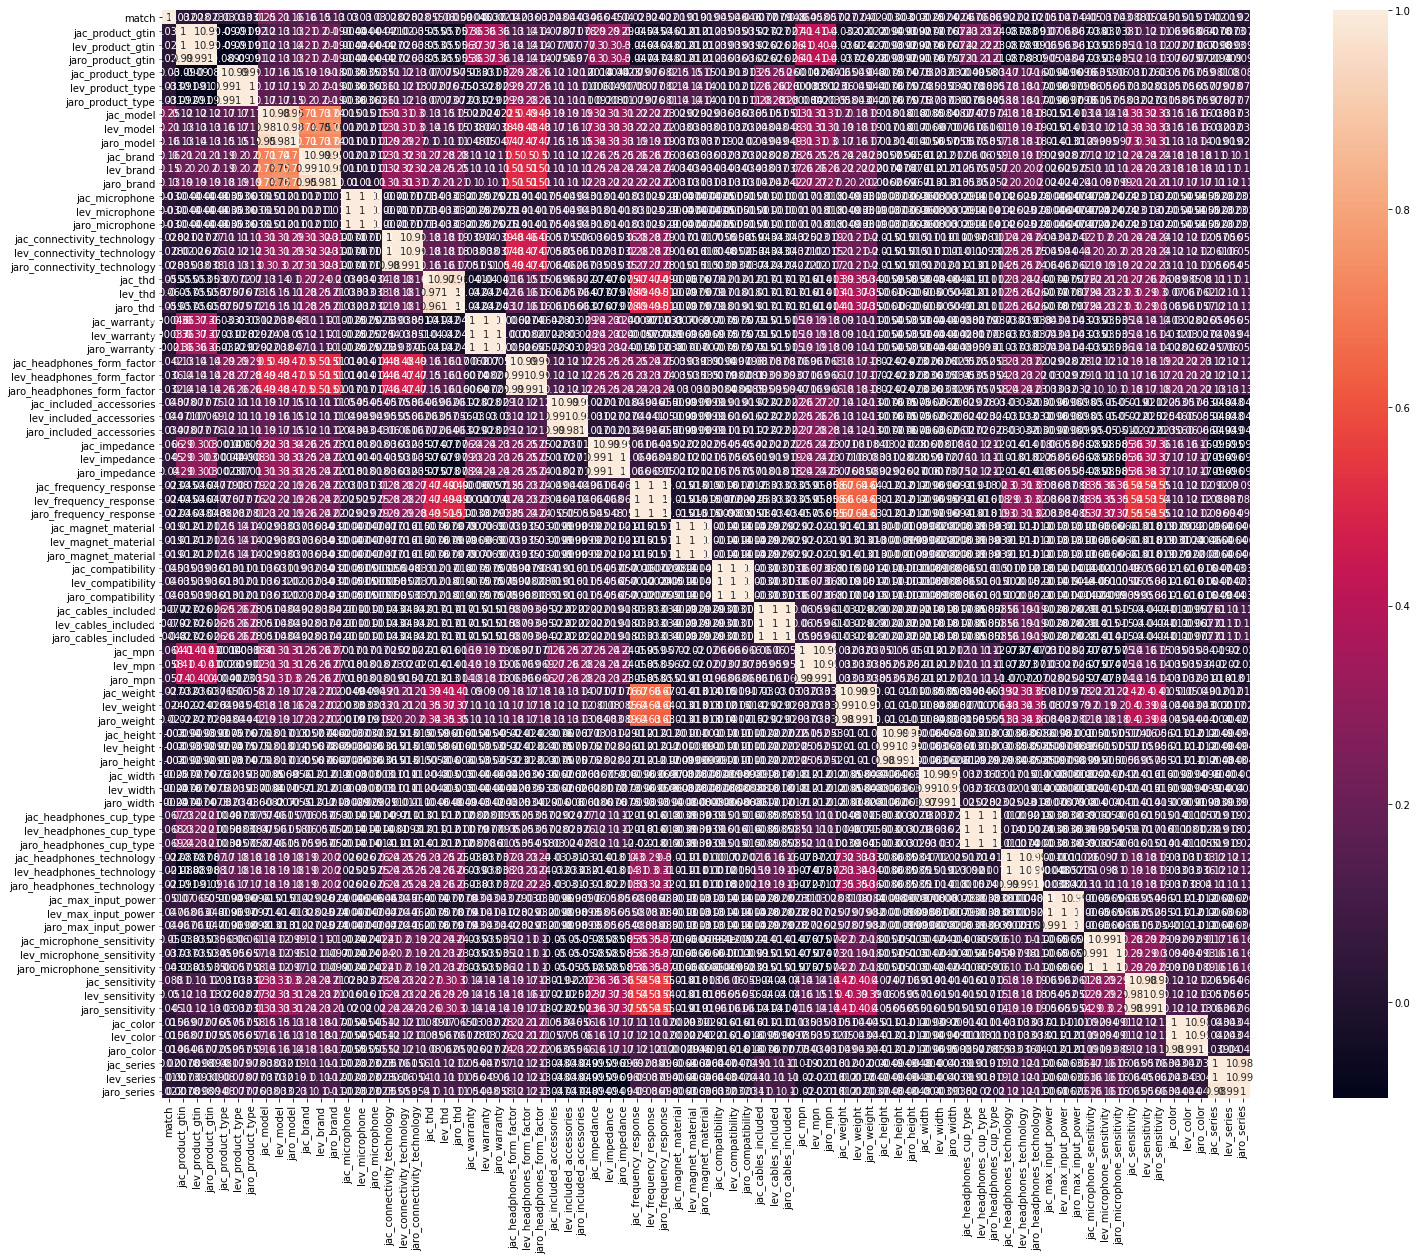

In [24]:
f, ax = plt.subplots(figsize=(30, 20))
sbn.heatmap(corrmat, vmax=1, cbar=True, annot=True, square=True)
plt.show()

# 1. USING ONLY JACCARD

- Modeling Parameters

In [25]:
cols = jac_columns_el.copy()

In [26]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

# filter the train and test according to its columns
X_train = np.array(pd.DataFrame(X_train).iloc[:,get_columns(cols_all, cols)])
X_test = np.array(pd.DataFrame(X_test).iloc[:,get_columns(cols_all, cols)])

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)


In [27]:
X_train.shape

(15468, 26)

In [28]:
df2.shape

(23087, 133)

In [29]:
run_=10
missing_option='opt4'
features='onlyjac'

- Model Results (pure)

In [30]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.8939393939393939
7546
3
11
59


In [31]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.9022556390977443
7546
3
10
60


In [32]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.9705882352941176
7549
0
4
66


In [33]:
f1_score_rf, tn_rf, fp_rf, fn_rf, tp_rf = get_base_model_result(y_test, y_train, X_test, X_train, RandomForestClassifier())
print(f1_score_rf)
print(tn_rf)
print(fp_rf)
print(fn_rf)
print(tp_rf)

0.962962962962963
7549
0
5
65


In [34]:
X_train.shape

(15468, 26)

## 1.1. Random Sampling

In [35]:
q_type='random'

### 1.1.1. Logistic Regression

In [36]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
350.3614890575409


(0, 1)

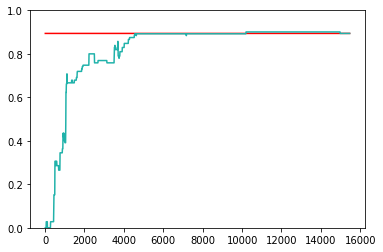

In [37]:
plt.plot(q_r_log, [f1_score_log] * (len(q_r_log)), '-r')
plt.plot(q_r_log, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)

### 1.1.2. Support Vector Machine

In [38]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9022556390977443
Current progress: 100.0 %
473.72286224365234


(0, 1)

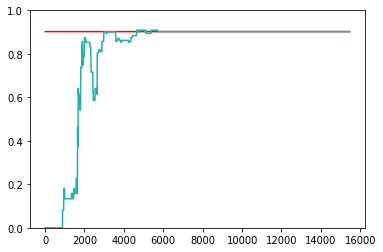

In [39]:
plt.plot(q_r_svm, [f1_score_svm] * (len(q_r_svm)), '-r')
plt.plot(q_r_svm, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 1.1.3. Decision Tree

In [40]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_dt, iter_r_dt, f1score_r_dt, tn_r_dt, fp_r_dt,fn_r_dt, tp_r_dt, k_r_dt, trn_dss_r_dt, label_holder_r_dt, asked_id_r_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9635036496350364
Current progress: 100.0 %
313.56541991233826


(0, 1)

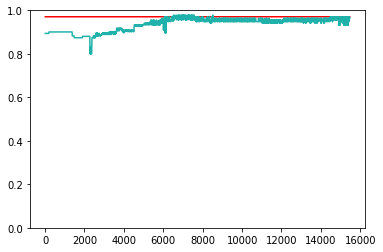

In [41]:
plt.plot(q_r_dt, [f1_score_dt] * (len(q_r_dt)), '-r')
plt.plot(q_r_dt, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 1.1.4. Random Forest Regression

In [42]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_rf, iter_r_rf, f1score_r_rf, tn_r_rf, fp_r_rf,fn_r_rf, tp_r_rf, k_r_rf, trn_dss_r_rf, label_holder_r_rf, asked_id_r_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.955223880597015
Current progress: 100.0 %
357.3217749595642


(0, 1)

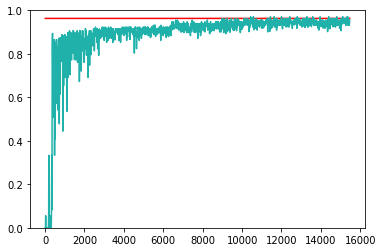

In [43]:
plt.plot(q_r_rf, [f1_score_rf] * (len(q_r_rf)), '-r')
plt.plot(q_r_rf, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

## 1.2. Uncertainity Sampling

In [44]:
q_type='uncertainity'

### 1.2.1. Logistic Regression

In [45]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
1477.6422278881073


(0, 1)

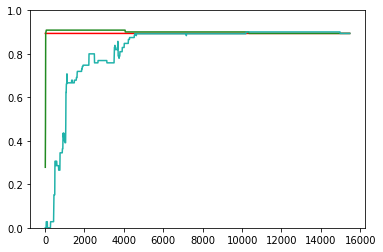

In [46]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 1.2.2. Support Vector Machine

In [47]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9022556390977443
Current progress: 100.0 %
3237.9508080482483


(0, 1)

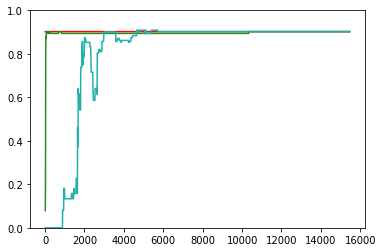

In [48]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 1.2.3. Decision Tree

In [49]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_dt, iter_u_dt, f1score_u_dt, tn_u_dt, fp_u_dt,fn_u_dt, tp_u_dt, k_u_dt, trn_dss_u_dt, label_holder_u_dt, asked_id_u_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9705882352941176
Current progress: 100.0 %
767.3396008014679


(0, 1)

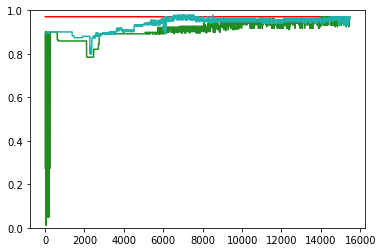

In [50]:
plt.plot(q_u_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_u_dt, f1score_u_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 1.2.4. Random Forest

In [51]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_rf, iter_u_rf, f1score_u_rf, tn_u_rf, fp_u_rf,fn_u_rf, tp_u_rf, k_u_rf, trn_dss_u_rf, label_holder_u_rf, asked_id_u_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9393939393939393
Current progress: 100.0 %
1258.933236837387


(0, 1)

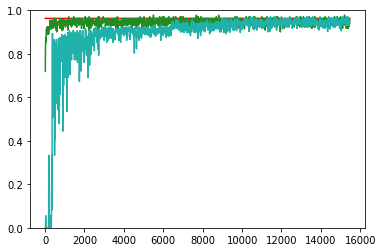

In [52]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_log, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

(all plot)

(0, 1)

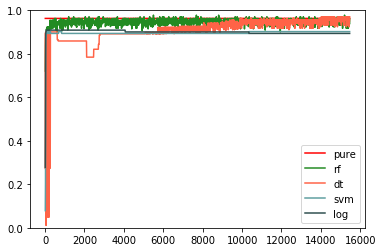

In [53]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_rf, f1score_u_dt, 'tomato')
plt.plot(q_u_rf, f1score_u_svm, 'cadetblue')
plt.plot(q_u_rf, f1score_u_log, 'darkslategray')

plt.legend((('pure','rf','dt','svm','log')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

## 1.3. Query by Committee

In [54]:
q_type='qbc'

### 1.3.1. Mix of all the models

In [55]:
alg='mixall'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
    SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM(),])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
6563.023866176605


(0, 1)

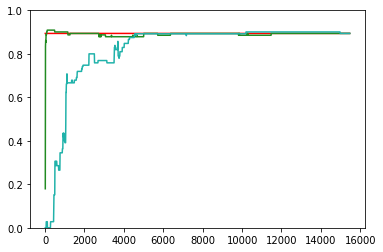

In [56]:
plt.plot(q_qbc_mix, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 1.3.2. Only Logistic Regression

In [57]:
alg='onlylog'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    LogisticRegression(C=1.0),
                    LogisticRegression(C=0.1),
                ])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
3821.9531152248383


(0, 1)

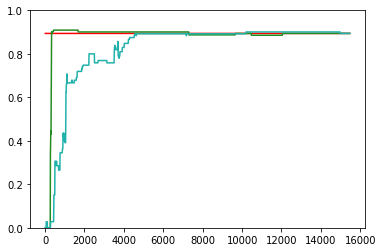

In [58]:
plt.plot(q_qbc_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log,'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 1.3.3. Only Desicion Tree

In [59]:
alg='onlydt'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='gini')),
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='entropy')),
                ])
model=SklearnProbaAdapter(tree.DecisionTreeClassifier('gini'))
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_dt, iter_qbc_dt, f1score_qbc_dt, tn_qbc_dt, fp_qbc_dt,fn_qbc_dt, tp_qbc_dt, k_qbc_dt, trn_dss_qbc_dt, label_holder_qbc_dt, asked_id_qbc_dt = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9705882352941176
Current progress: 100.0 %
2535.1865277290344


(0, 1)

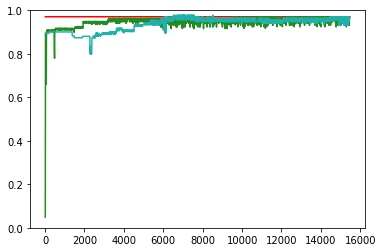

In [60]:
plt.plot(q_qbc_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_dt, f1score_qbc_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 1.3.4. Only Support Vector Machine

In [61]:
alg='onlysvm'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SVM(C=1.0),
                    SVM(C=0.1),
                ])

model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9022556390977443
Current progress: 100.0 %
8884.658279895782


(0, 1)

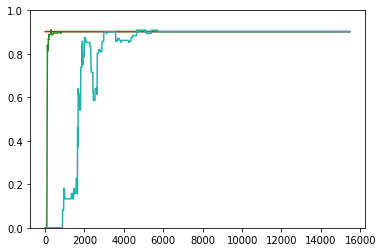

In [62]:
plt.plot(q_qbc_svc, [f1_score_svm] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc,'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

(all plot)

(0, 1)

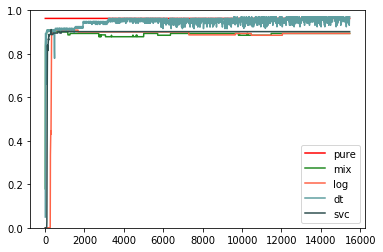

In [63]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_rf, f1score_qbc_log, 'tomato')
plt.plot(q_u_rf, f1score_qbc_dt, 'cadetblue')
plt.plot(q_u_rf, f1score_qbc_svc, 'darkslategray')

plt.legend((('pure','mix','log','dt','svc')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

# 2. USING ONLY LEVENSTEIN

In [64]:
cols = lev_columns_el.copy()

- Modeling Parameters

In [65]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

# filter the train and test according to its columns
X_train = np.array(pd.DataFrame(X_train).iloc[:,get_columns(cols_all, cols)])
X_test = np.array(pd.DataFrame(X_test).iloc[:,get_columns(cols_all, cols)])

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)


In [66]:
run_=10
missing_option='opt4'
features='onlylev'

- Model Results (pure)

In [67]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.796875
7542
7
19
51


In [68]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.20512820512820512
7549
0
62
8


In [69]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.8689655172413793
7537
12
7
63


In [70]:
f1_score_rf, tn_rf, fp_rf, fn_rf, tp_rf = get_base_model_result(y_test, y_train, X_test, X_train, RandomForestClassifier())
print(f1_score_rf)
print(tn_rf)
print(fp_rf)
print(fn_rf)
print(tp_rf)

0.923076923076923
7549
0
10
60


## 2.1. Random Sampling

In [71]:
q_type='random'

## 2.1.1. Logistic Regression

In [72]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.796875
Current progress: 100.0 %
411.8030700683594


(0, 1)

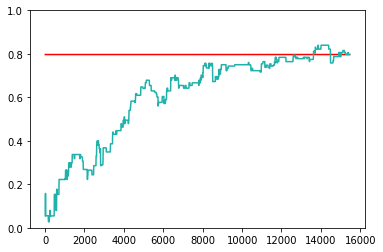

In [73]:
plt.plot(q_u_svm, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)

## 2.1.2. Support Vector Machines

In [74]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.20512820512820512
Current progress: 100.0 %
605.4068610668182


(0, 1)

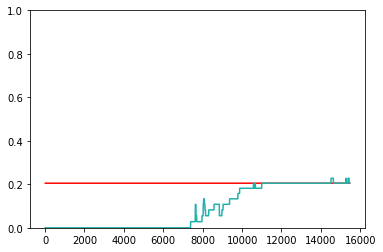

In [75]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)


## 2.1.3. Decision Trees

In [76]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_dt, iter_r_dt, f1score_r_dt, tn_r_dt, fp_r_dt,fn_r_dt, tp_r_dt, k_r_dt, trn_dss_r_dt, label_holder_r_dt, asked_id_r_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9090909090909091
Current progress: 100.0 %
337.7718451023102


(0, 1)

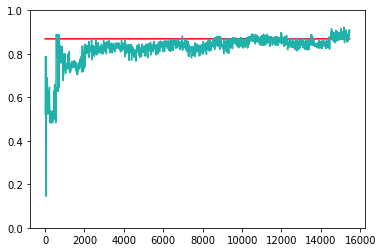

In [77]:
plt.plot(q_u_svm, [f1_score_dt] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)


## 2.1.4. Random Forest Regression

In [78]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_rf, iter_r_rf, f1score_r_rf, tn_r_rf, fp_r_rf,fn_r_rf, tp_r_rf, k_r_rf, trn_dss_r_rf, label_holder_r_rf, asked_id_r_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9022556390977443
Current progress: 100.0 %
398.9884660243988


(0, 1)

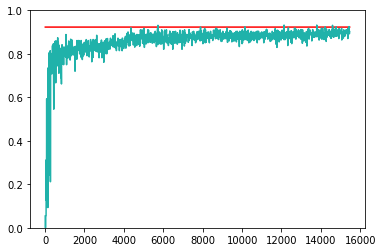

In [79]:
plt.plot(q_u_svm, [f1_score_rf] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

## 2.2. Uncertainity Sampling

In [80]:
q_type='uncertainity'

### 2.2.1. Logistic Regression

In [81]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.796875
Current progress: 100.0 %
1914.9691100120544


(0, 1)

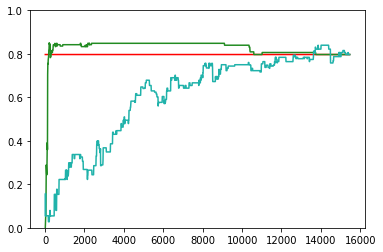

In [82]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 2.2.2. Support Vector Machine

In [83]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.20512820512820512
Current progress: 100.0 %
5243.623034954071


(0, 1)

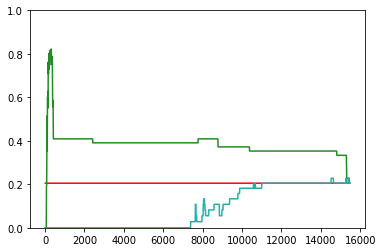

In [84]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 2.2.3. Decision Tree

In [85]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_dt, iter_u_dt, f1score_u_dt, tn_u_dt, fp_u_dt,fn_u_dt, tp_u_dt, k_u_dt, trn_dss_u_dt, label_holder_u_dt, asked_id_u_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8827586206896552
Current progress: 100.0 %
935.7286858558655


(0, 1)

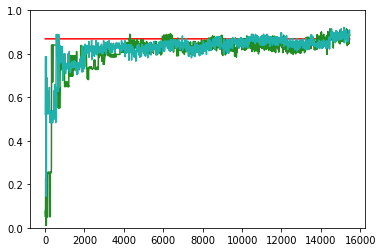

In [86]:
plt.plot(q_u_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_u_dt, f1score_u_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 2.2.4. Random Forest

In [87]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_rf, iter_u_rf, f1score_u_rf, tn_u_rf, fp_u_rf,fn_u_rf, tp_u_rf, k_u_rf, trn_dss_u_rf, label_holder_u_rf, asked_id_u_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9051094890510949
Current progress: 100.0 %
1448.3315410614014


(0, 1)

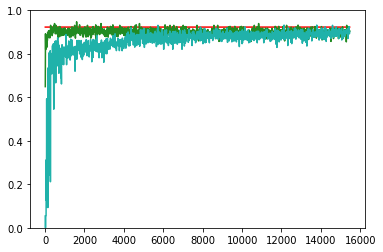

In [88]:

plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_log, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

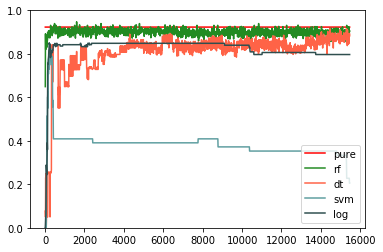

In [89]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_rf, f1score_u_dt, 'tomato')
plt.plot(q_u_rf, f1score_u_svm, 'cadetblue')
plt.plot(q_u_rf, f1score_u_log, 'darkslategray')

plt.legend((('pure','rf','dt','svm','log')),loc='lower right')
#plt.gca().legend(('y0','y1'))
plt.ylim(0, 1)

## 2.3. Query by Committee

In [90]:
q_type='qbc'

### 2.3.1. Mix of all the models

In [91]:
alg='mixall'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
    SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM(),])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.796875
Current progress: 100.0 %
9457.73842382431


(0, 1)

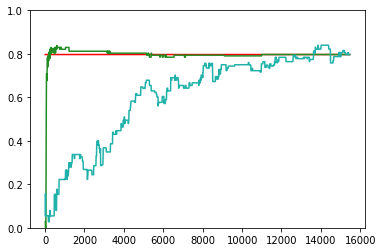

In [92]:
plt.plot(q_qbc_mix, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 2.3.2. Only Logistic Regression

In [93]:
alg='onlylog'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    LogisticRegression(C=1.0),
                    LogisticRegression(C=0.1),
                ])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.796875
Current progress: 100.0 %
4172.150624036789


(0, 1)

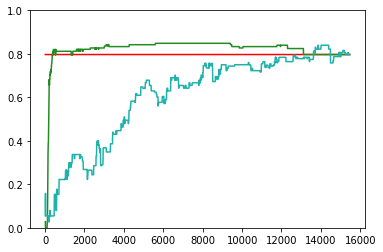

In [94]:
plt.plot(q_qbc_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log,'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 2.3.3. Only Desicion Tree

In [95]:
alg='onlydt'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='gini')),
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='entropy')),
                ])
model=SklearnProbaAdapter(tree.DecisionTreeClassifier('gini'))
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_dt, iter_qbc_dt, f1score_qbc_dt, tn_qbc_dt, fp_qbc_dt,fn_qbc_dt, tp_qbc_dt, k_qbc_dt, trn_dss_qbc_dt, label_holder_qbc_dt, asked_id_qbc_dt = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8857142857142857
Current progress: 100.0 %
2609.0672612190247


(0, 1)

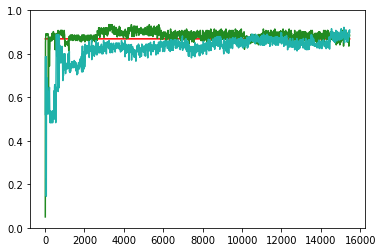

In [96]:
plt.plot(q_qbc_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_dt, f1score_qbc_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 2.3.4. Only Support Vector Machine

In [97]:
alg='onlysvm'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SVM(C=1.0),
                    SVM(C=0.1),
                ])

model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.20512820512820512
Current progress: 100.0 %
9759.654277086258


(0, 1)

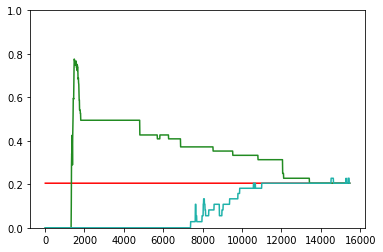

In [98]:
plt.plot(q_qbc_svc, [f1_score_svm] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc,'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

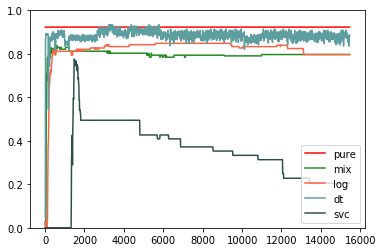

In [99]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_rf, f1score_qbc_log, 'tomato')
plt.plot(q_u_rf, f1score_qbc_dt, 'cadetblue')
plt.plot(q_u_rf, f1score_qbc_svc, 'darkslategray')

plt.legend((('pure','mix','log','dt','svc')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

# 3. USING ONLY JARO-WINKLER

In [100]:
cols = jaro_columns_el.copy()

- Modeling Parameters

In [101]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

# filter the train and test according to its columns
X_train = np.array(pd.DataFrame(X_train).iloc[:,get_columns(cols_all, cols)])
X_test = np.array(pd.DataFrame(X_test).iloc[:,get_columns(cols_all, cols)])

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)

In [102]:
run_=10
missing_option='opt4'
features='onlyjaro'

- Model Results (pure)

In [103]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.3777777777777778
7546
3
53
17


In [104]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.0
7549
0
70
0


In [105]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.9103448275862068
7540
9
4
66


In [106]:
f1_score_rf, tn_rf, fp_rf, fn_rf, tp_rf = get_base_model_result(y_test, y_train, X_test, X_train, RandomForestClassifier())
print(f1_score_rf)
print(tn_rf)
print(fp_rf)
print(fn_rf)
print(tp_rf)


0.916030534351145
7548
1
10
60


## 3.1. Random Sampling

In [107]:
q_type='random'

### 3.1.1. Logistic Regression

In [108]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.3777777777777778
Current progress: 100.0 %
391.4311032295227


(0, 1)

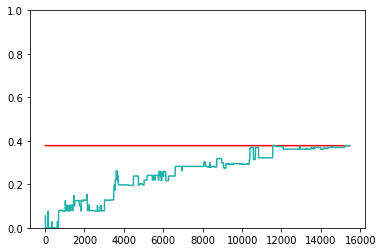

In [109]:
plt.plot(q_u_svm, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)


### 3.1.2. Support Vector Machine

In [110]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.0
Current progress: 100.0 %
592.7882680892944


(0, 1)

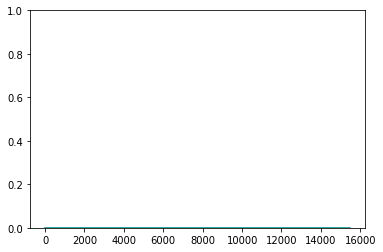

In [111]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)


### 3.1.3. Decision Tree

In [112]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_dt, iter_r_dt, f1score_r_dt, tn_r_dt, fp_r_dt,fn_r_dt, tp_r_dt, k_r_dt, trn_dss_r_dt, label_holder_r_dt, asked_id_r_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8794326241134751
Current progress: 100.0 %
315.8140571117401


(0, 1)

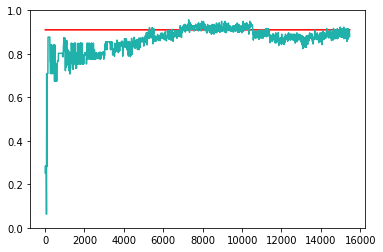

In [113]:
plt.plot(q_u_svm, [f1_score_dt] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)


### 3.1.4. Random Forest

In [114]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_rf, iter_r_rf, f1score_r_rf, tn_r_rf, fp_r_rf,fn_r_rf, tp_r_rf, k_r_rf, trn_dss_r_rf, label_holder_r_rf, asked_id_r_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9007633587786259
Current progress: 100.0 %
354.39249777793884


(0, 1)

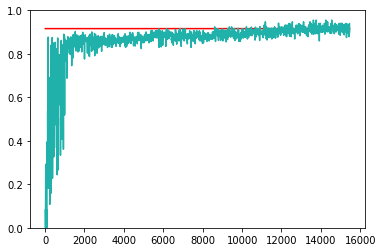

In [115]:
plt.plot(q_u_svm, [f1_score_rf] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)


## 3.2. Uncertainity Sampling

In [116]:
q_type='uncertainity'

### 3.2.1. Logistic Regression

In [117]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.3777777777777778
Current progress: 100.0 %
1727.6849212646484


(0, 1)

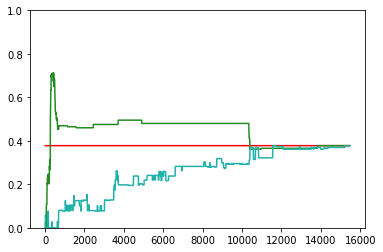

In [118]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 3.2.2. Support Vector Machine

In [119]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.0
Current progress: 100.0 %
5388.537680149078


(0, 1)

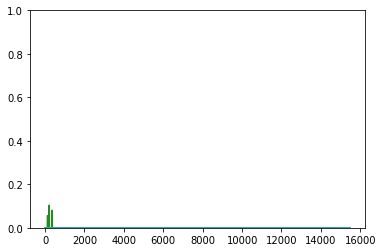

In [120]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 3.2.3. Decision Tree

In [121]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_dt, iter_u_dt, f1score_u_dt, tn_u_dt, fp_u_dt,fn_u_dt, tp_u_dt, k_u_dt, trn_dss_u_dt, label_holder_u_dt, asked_id_u_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8857142857142857
Current progress: 100.0 %
912.0253419876099


(0, 1)

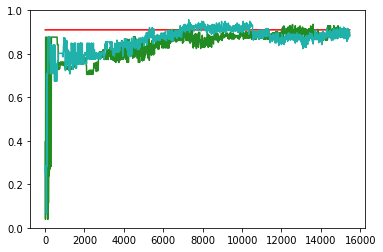

In [122]:
plt.plot(q_u_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_u_dt, f1score_u_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 3.2.4. Random Forest

In [123]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_rf, iter_u_rf, f1score_u_rf, tn_u_rf, fp_u_rf,fn_u_rf, tp_u_rf, k_u_rf, trn_dss_u_rf, label_holder_u_rf, asked_id_u_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9104477611940298
Current progress: 100.0 %
1412.888002872467


(0, 1)

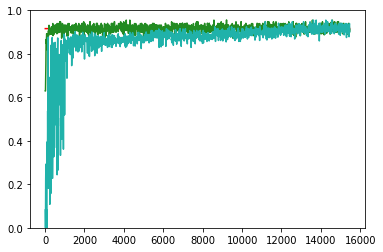

In [124]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_log, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)


(all models)

(0, 1)

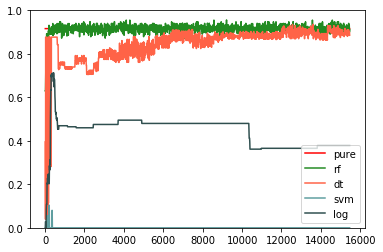

In [125]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_rf, f1score_u_dt, 'tomato')
plt.plot(q_u_rf, f1score_u_svm, 'cadetblue')
plt.plot(q_u_rf, f1score_u_log, 'darkslategray')

plt.legend((('pure','rf','dt','svm','log')),loc='lower right')
#plt.gca().legend(('y0','y1'))
plt.ylim(0, 1)

## 3.3. Query by Committee

In [126]:
q_type='qbc'

### 3.3.1. Mix of all the models

In [127]:
alg='mixall'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
    SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM(),])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.3777777777777778
Current progress: 100.0 %
9296.65533208847


(0, 1)

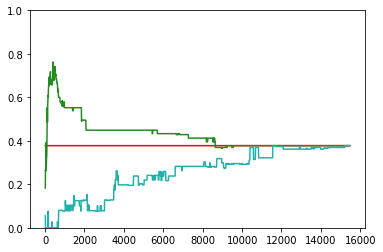

In [128]:
plt.plot(q_qbc_mix, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 3.3.2. Only Logistic Regression

In [129]:
alg='onlylog'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    LogisticRegression(C=1.0),
                    LogisticRegression(C=0.1),
                ])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.3777777777777778
Current progress: 100.0 %
4299.589087963104


(0, 1)

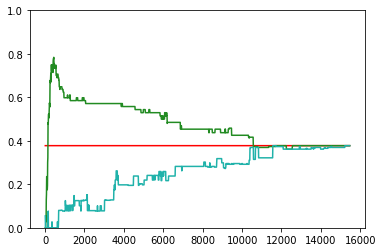

In [130]:
plt.plot(q_qbc_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log,'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 3.3.3. Only Desicion Tree

In [131]:
alg='onlydt'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='gini')),
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='entropy')),
                ])
model=SklearnProbaAdapter(tree.DecisionTreeClassifier('gini'))
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_dt, iter_qbc_dt, f1score_qbc_dt, tn_qbc_dt, fp_qbc_dt,fn_qbc_dt, tp_qbc_dt, k_qbc_dt, trn_dss_qbc_dt, label_holder_qbc_dt, asked_id_qbc_dt = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.8794326241134751
Current progress: 100.0 %
2790.5737960338593


(0, 1)

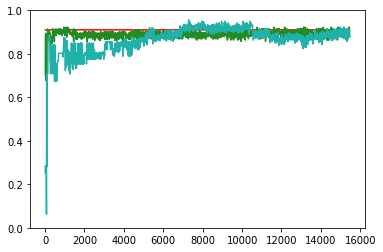

In [132]:
plt.plot(q_qbc_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_dt, f1score_qbc_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 3.3.4. Only Support Vector Machine

In [133]:
alg='onlysvm'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SVM(C=1.0),
                    SVM(C=0.1),
                ])

model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.0
Current progress: 100.0 %
7739.669161319733


(0, 1)

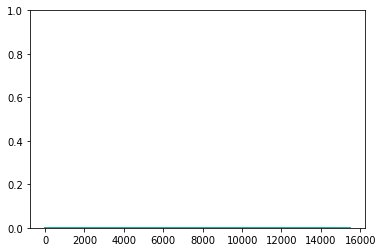

In [134]:
plt.plot(q_qbc_svc, [f1_score_svm] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc,'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

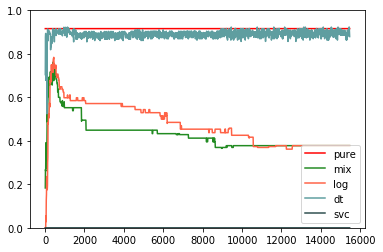

In [135]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_rf, f1score_qbc_log, 'tomato')
plt.plot(q_u_rf, f1score_qbc_dt, 'cadetblue')
plt.plot(q_u_rf, f1score_qbc_svc, 'darkslategray')

plt.legend((('pure','mix','log','dt','svc')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

# 4. ALL FEATURES

In [136]:
run_=10
missing_option='opt4'
features='all'

In [137]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)


- Model Results (pure)

In [138]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.887218045112782
7545
4
11
59


In [139]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.909090909090909
7547
2
10
60


In [140]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.9370629370629371
7543
6
3
67


In [141]:
f1_score_rf, tn_rf, fp_rf, fn_rf, tp_rf = get_base_model_result(y_test, y_train, X_test, X_train, RandomForestClassifier())
print(f1_score_rf)
print(tn_rf)
print(fp_rf)
print(fn_rf)
print(tp_rf)

0.9323308270676691
7548
1
8
62


## 4.1. Random Sampling

In [142]:
q_type='random'

## 4.1.1. Logistic Regression

In [143]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.887218045112782
Current progress: 100.0 %
629.0866799354553


(0, 1)

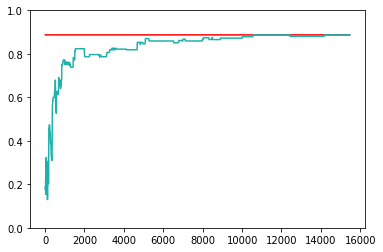

In [144]:
plt.plot(q_u_svm, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)

## 4.1.2. Support Vector Machines

In [145]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.909090909090909
Current progress: 100.0 %
929.377956867218


(0, 1)

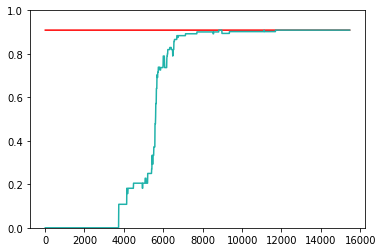

In [146]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)


## 4.1.3. Decision Trees

In [147]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_dt, iter_r_dt, f1score_r_dt, tn_r_dt, fp_r_dt,fn_r_dt, tp_r_dt, k_r_dt, trn_dss_r_dt, label_holder_r_dt, asked_id_r_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9510489510489512
Current progress: 100.0 %
431.10324573516846


(0, 1)

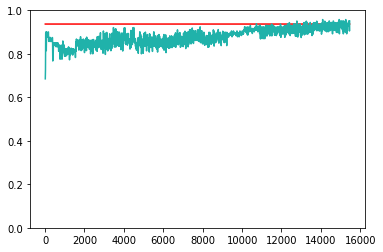

In [148]:
plt.plot(q_u_svm, [f1_score_dt] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)


## 4.1.4. Random Forest Regression

In [149]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_rf, iter_r_rf, f1score_r_rf, tn_r_rf, fp_r_rf,fn_r_rf, tp_r_rf, k_r_rf, trn_dss_r_rf, label_holder_r_rf, asked_id_r_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9635036496350364
Current progress: 100.0 %
388.0563609600067


(0, 1)

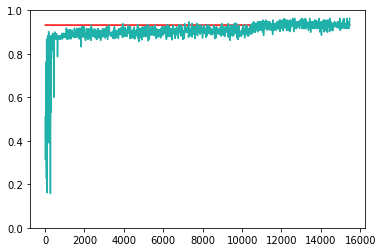

In [150]:
plt.plot(q_u_svm, [f1_score_rf] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

## 4.2. Uncertainity Sampling

In [151]:
q_type='uncertainity'

### 4.2.1. Logistic Regression

In [152]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.887218045112782
Current progress: 100.0 %
3980.2548360824585


(0, 1)

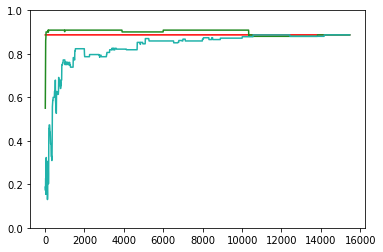

In [153]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 4.2.2. Support Vector Machine

In [154]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.909090909090909
Current progress: 100.0 %
9494.219871044159


(0, 1)

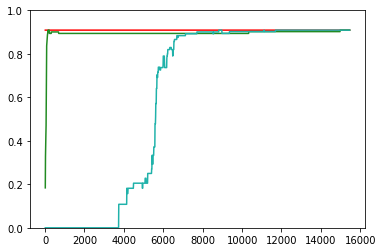

In [155]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 4.2.3. Decision Tree

In [156]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_dt, iter_u_dt, f1score_u_dt, tn_u_dt, fp_u_dt,fn_u_dt, tp_u_dt, k_u_dt, trn_dss_u_dt, label_holder_u_dt, asked_id_u_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9295774647887323
Current progress: 100.0 %
1890.2109081745148


(0, 1)

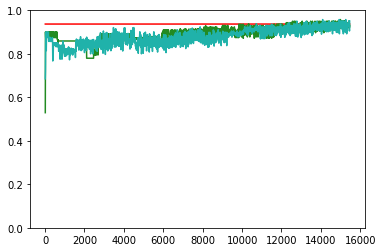

In [157]:
plt.plot(q_u_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_u_dt, f1score_u_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 4.2.4. Random Forest

In [158]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_rf, iter_u_rf, f1score_u_rf, tn_u_rf, fp_u_rf,fn_u_rf, tp_u_rf, k_u_rf, trn_dss_u_rf, label_holder_u_rf, asked_id_u_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9481481481481482
Current progress: 100.0 %
1823.7553741931915


(0, 1)

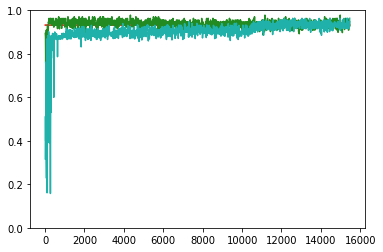

In [159]:

plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_log, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

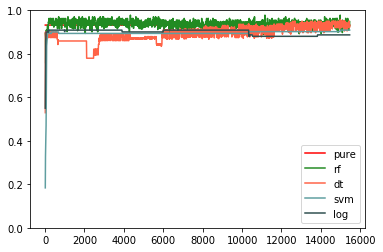

In [160]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_rf, f1score_u_dt, 'tomato')
plt.plot(q_u_rf, f1score_u_svm, 'cadetblue')
plt.plot(q_u_rf, f1score_u_log, 'darkslategray')

plt.legend((('pure','rf','dt','svm','log')),loc='lower right')
#plt.gca().legend(('y0','y1'))
plt.ylim(0, 1)

## 4.3. Query by Committee

In [161]:
q_type='qbc'

### 4.3.1. Mix of all the models

In [162]:
alg='mixall'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
    SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM(),])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.887218045112782
Current progress: 100.0 %
15953.937538146973


(0, 1)

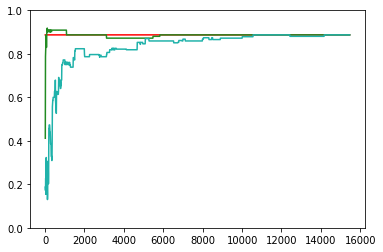

In [163]:
plt.plot(q_qbc_mix, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 4.3.2. Only Logistic Regression

In [164]:
alg='onlylog'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    LogisticRegression(C=1.0),
                    LogisticRegression(C=0.1),
                ])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.887218045112782
Current progress: 100.0 %
7927.67723274231


(0, 1)

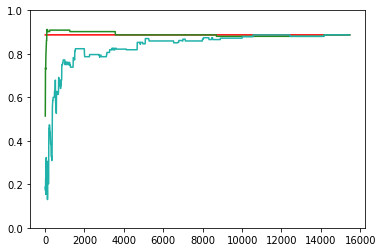

In [165]:
plt.plot(q_qbc_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log,'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 4.3.3. Only Desicion Tree

In [166]:
alg='onlydt'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='gini')),
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='entropy')),
                ])
model=SklearnProbaAdapter(tree.DecisionTreeClassifier('gini'))
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_dt, iter_qbc_dt, f1score_qbc_dt, tn_qbc_dt, fp_qbc_dt,fn_qbc_dt, tp_qbc_dt, k_qbc_dt, trn_dss_qbc_dt, label_holder_qbc_dt, asked_id_qbc_dt = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.9142857142857143
Current progress: 100.0 %
3953.4024567604065


(0, 1)

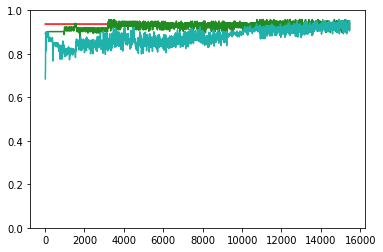

In [167]:
plt.plot(q_qbc_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_dt, f1score_qbc_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 4.3.4. Only Support Vector Machine

In [168]:
alg='onlysvm'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SVM(C=1.0),
                    SVM(C=0.1),
                ])

model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
train dataset labeled: 15468
train dataset sum: 194
Current f1 score: 0.909090909090909
Current progress: 100.0 %
19970.8031437397


(0, 1)

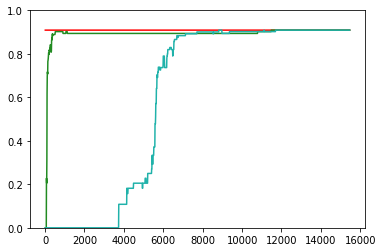

In [169]:
plt.plot(q_qbc_svc, [f1_score_svm] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc,'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

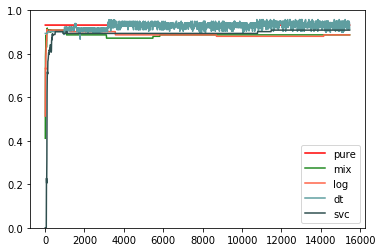

In [170]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_rf, f1score_qbc_log, 'tomato')
plt.plot(q_u_rf, f1score_qbc_dt, 'cadetblue')
plt.plot(q_u_rf, f1score_qbc_svc, 'darkslategray')

plt.legend((('pure','mix','log','dt','svc')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

# 5. FEATURE SELECTION

- Modeling Parameters

In [171]:
run_=10
missing_option='opt4'
features='fetselect'

In [172]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)


- Model results (choose features) -> F-Classification

In [173]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif


X_new = SelectKBest(f_classif, k=20).fit(X_train, y_train)
mask = X_new.get_support() #list of booleans
new_features_f = [] # The list of your K best features

for bool, feature in zip(mask, cols_all):
    if bool:
        new_features_f.append(feature)

col_index=[cols_all.index(i) for i in new_features_f]
X_test_feature=[i[col_index] for i in X_test]
X_train_feature=[i[col_index] for i in X_train]

In [174]:
new_features_f

['jac_model',
 'jac_brand',
 'jac_thd',
 'jac_impedance',
 'jac_mpn',
 'jac_headphones_cup_type',
 'jac_sensitivity',
 'lev_model',
 'lev_brand',
 'lev_thd',
 'lev_impedance',
 'lev_mpn',
 'lev_headphones_cup_type',
 'lev_sensitivity',
 'jaro_model',
 'jaro_brand',
 'jaro_thd',
 'jaro_mpn',
 'jaro_headphones_cup_type',
 'jaro_sensitivity']

In [175]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log_fclass, tn_log_fclass, fp_log_fclass, fn_log_fclass, tp_log_fclass = get_base_model_result(y_test, y_train, X_test_feature, X_train_feature, ls())
print(f1_score_log_fclass)
print(tn_log_fclass)
print(fp_log_fclass)
print(fn_log_fclass)
print(tp_log_fclass)

0.8923076923076922
7547
2
12
58


In [176]:
from sklearn.svm import SVC as support_vector
f1_score_svm_fclass, tn_svm_fclass, fp_svm_fclass, fn_svm_fclass, tp_svm_fclass = get_base_model_result(y_test, y_train, X_test_feature, X_train_feature, support_vector())
print(f1_score_svm_fclass)
print(tn_svm_fclass)
print(fp_svm_fclass)
print(fn_svm_fclass)
print(tp_svm_fclass)

0.8939393939393939
7546
3
11
59


In [177]:
from sklearn import tree
f1_score_dt_fclass, tn_dt_fclass, fp_dt_fclass, fn_dt_fclass, tp_dt_fclass = get_base_model_result(y_test, y_train, X_test_feature, X_train_feature, tree.DecisionTreeClassifier())
print(f1_score_dt_fclass)
print(tn_dt_fclass)
print(fp_dt_fclass)
print(fn_dt_fclass)
print(tp_dt_fclass)

0.920863309352518
7544
5
6
64


In [178]:
f1_score_rf_fclass, tn_rf_fclass, fp_rf_fclass, fn_rf_fclass, tp_rf_fclass = get_base_model_result(y_test, y_train, X_test_feature, X_train_feature, RandomForestClassifier())
print(f1_score_rf_fclass)
print(tn_rf_fclass)
print(fp_rf_fclass)
print(fn_rf_fclass)
print(tp_rf_fclass)

0.9117647058823529
7545
4
8
62


## 5.1. Random Sampling

In [179]:
q_type='random'

In [180]:
run_

10

### 5.1.1. Logistic Regression

In [181]:
alg='log'
model_ = LogisticRegression()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method=method_, model=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log, featur_log_r = run_featureselection(trn_ds, tst_ds, y_train, model_, method_, qs, X_test, y_test, cols_all, name,True,'random', run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 78)
train dataset sum: 194
Current f1 score: 0.8923076923076922
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_thd', 'jac_included_accessories', 'jac_impedance', 'jac_mpn', 'jac_headphones_cup_type', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'lev_sensitivity', 'jaro_model', 'jaro_brand', 'jaro_thd', 'jaro_mpn', 'jaro_headphones_cup_type']
969.443708896637


(0, 1)

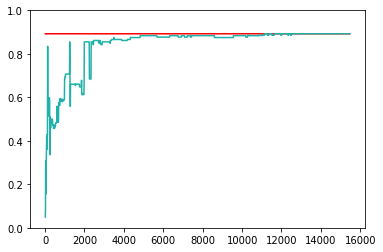

In [182]:
plt.plot(q_r_log, [f1_score_log_fclass] * (len(q_r_log)), '-r')
plt.plot(q_r_log, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)

In [183]:
start_time

1564211305.737637

### 5.1.2. Support Vector Machine

In [184]:
alg='svm'
model_ = SVM()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method=method_, model=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm, featur_r_svm = run_featureselection(trn_ds, tst_ds, y_train, model_, method_, qs, X_test, y_test, cols_all, name,True,'random', run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 78)
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_thd', 'jac_impedance', 'jac_mpn', 'jac_headphones_cup_type', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'lev_sensitivity', 'jaro_model', 'jaro_brand', 'jaro_thd', 'jaro_mpn', 'jaro_headphones_cup_type', 'jaro_sensitivity']
1063.4663009643555


(0, 1)

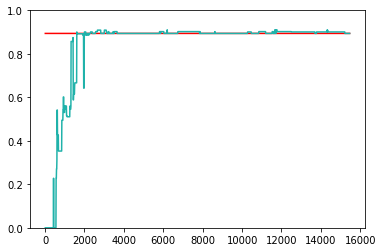

In [185]:
plt.plot(q_r_svm, [f1_score_svm_fclass] * (len(q_r_svm)), '-r')
plt.plot(q_r_svm, f1score_r_svm,'lightseagreen')
plt.ylim(0, 1)

## 5.2. Uncertainty Sampling

In [186]:
q_type='uncertainity'

### 5.2.1. Logistic Regression

In [187]:
alg='log'
model_ = LogisticRegression()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method=method_, model=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log, featur_log_u = run_featureselection(trn_ds, tst_ds, y_train, model_,method_, qs, X_test, y_test,cols_all,name,True,'unc',run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 78)
train dataset sum: 194
Current f1 score: 0.8923076923076922
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_thd', 'jac_impedance', 'jac_mpn', 'jac_headphones_cup_type', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'lev_sensitivity', 'jaro_model', 'jaro_brand', 'jaro_thd', 'jaro_mpn', 'jaro_headphones_cup_type', 'jaro_sensitivity']
2247.1810460090637


(0, 1)

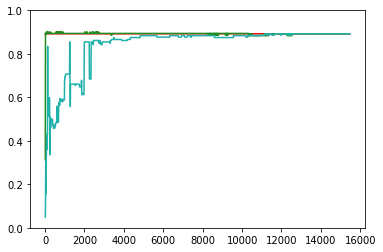

In [188]:
plt.plot(q_u_log, [f1_score_log_fclass] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 5.1.2. Support Vector Machine

In [189]:
alg='svm'
model_=SVM()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method=method_, model=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm, featur_log_svm = run_featureselection(trn_ds, tst_ds, y_train, model_,method_, qs, X_test, y_test,cols_all,name,True,'unc',run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 78)
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_thd', 'jac_impedance', 'jac_mpn', 'jac_headphones_cup_type', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'lev_sensitivity', 'jaro_model', 'jaro_brand', 'jaro_thd', 'jaro_mpn', 'jaro_headphones_cup_type', 'jaro_sensitivity']
3667.2949113845825


(0, 1)

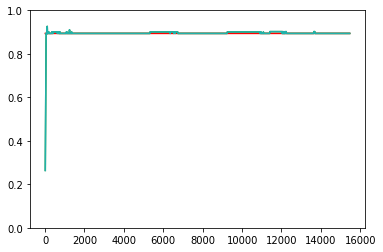

In [190]:
plt.plot(q_u_svm, [f1_score_svm_fclass] * (len(q_u_svm)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_svm, f1score_u_svm, 'lightseagreen')
plt.ylim(0, 1)


## 5.4. Query by Committee

In [191]:
q_type='qbc'

### 5.4.1. Mix of all the models

In [192]:
alg='mixall'
model_= [SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM()]
method_=LogisticRegression()
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix, featur_log_qbc = run_featureselection(trn_ds, tst_ds, y_train, model_,method_, qs,X_test, y_test,cols_all,name,True,'qbc',run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 78)
train dataset sum: 194
Current f1 score: 0.8923076923076922
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_thd', 'jac_impedance', 'jac_mpn', 'jac_headphones_cup_type', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'lev_sensitivity', 'jaro_model', 'jaro_brand', 'jaro_thd', 'jaro_mpn', 'jaro_headphones_cup_type', 'jaro_sensitivity']
20404.378128051758


(0, 1)

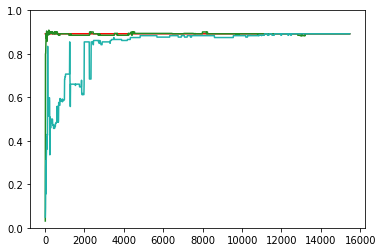

In [193]:
plt.plot(q_qbc_mix, [f1_score_log_fclass] * (len(q_qbc_mix)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_qbc_mix, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 5.4.2. Only Logistic Regression

In [194]:
alg='log'
model_= [LogisticRegression(C=1.0),
        LogisticRegression(C=0.1)]
method_=LogisticRegression()
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log, featur_loglog_qbc = run_featureselection(trn_ds, tst_ds, y_train, model_, method_,qs,X_test, y_test,cols_all,name,True,'qbc',run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 78)
train dataset sum: 194
Current f1 score: 0.8923076923076922
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_thd', 'jac_impedance', 'jac_mpn', 'jac_headphones_cup_type', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'lev_sensitivity', 'jaro_model', 'jaro_brand', 'jaro_thd', 'jaro_mpn', 'jaro_headphones_cup_type', 'jaro_sensitivity']
13498.199676275253


(0, 1)

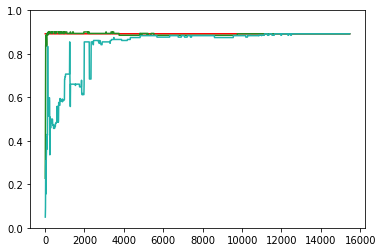

In [195]:
plt.plot(q_qbc_log, [f1_score_log_fclass] * (len(q_qbc_log)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log, 'forestgreen')
plt.plot(q_qbc_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 5.4.3. Only Support Vector Machine

In [196]:
alg='svm'
model_= [SVM(C=1.0),
         SVM(C=0.1)]
method_=SVM()
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc, featur_svm_qbc = run_featureselection(trn_ds, tst_ds, y_train, model_, method_, qs, X_test, y_test,cols_all,name,True,'qbc',run_)
end_time = time.time()
print(end_time-start_time)

15468
15468
iteration: 1545
1546
train dataset labeled: 15468
train dataset shape: (15468, 78)
train dataset sum: 194
Current f1 score: 0.8939393939393939
Current progress: 100.0 %
Chosen_features: ['jac_model', 'jac_brand', 'jac_thd', 'jac_impedance', 'jac_mpn', 'jac_headphones_cup_type', 'jac_sensitivity', 'lev_model', 'lev_brand', 'lev_thd', 'lev_impedance', 'lev_mpn', 'lev_headphones_cup_type', 'lev_sensitivity', 'jaro_model', 'jaro_brand', 'jaro_thd', 'jaro_mpn', 'jaro_headphones_cup_type', 'jaro_sensitivity']
20981.01064181328


(0, 1)

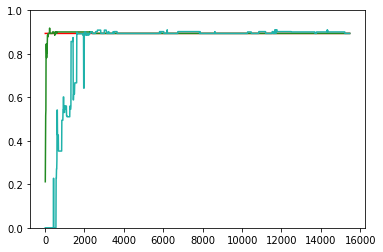

In [199]:
plt.plot(q_qbc_svc, [f1_score_svm_fclass] * (len(q_qbc_log)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc, 'forestgreen')
plt.plot(q_qbc_svc, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)